# Проект: "Предсказание покупки"

<b>Описание:</b> интернет-магазин собрал данные на основе покупок клиентов и рассылок им. Требуется провести анализ и обучить модель

<b>Цель:</b> предсказать будет ли клиент совершать покупку в ближайшие 90 дней

<b>Задачи:</b> провести предобработку данных, исследовательский анализ данных, создать новые признаки и обучить модель на них

<b>Исходные данные:</b> Нам даны пять таблиц, в первой собраны данные по покупакам клиентов, во второй - данные по рассылкам, третья таблица содержит в себе таргет, то есть совершит ли данный клиент покупку в течение 90 дней. Четвертая и пятая таблица содержат в себе агрегированные данные со второй таблицей, где были посчитаны типы ивентов и количество уникальных пользователей, которых охватил данный тип ивента для заданного временного отрезка, отличие этих таблиц состоит в том, что в пятой таблице в два раза больше признаков, так как ко всему этому еще добавляется деление на канал рассылки - пуш-уведомление или емейл

## Загрузка данных

### Подгрузка библиотек

In [1]:
!pip install phik -q

In [2]:
!pip install category_encoders -q

In [3]:
!pip install scikit-learn==1.1.3 -q

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
import ast

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import CatBoostEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Задание констант

In [5]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Написание класса

In [6]:
class EDA:
    
    def __init__(self, filepath):
        self.filepath = filepath
        try:
            self.df = self.read_data()
            print('Данные загружены')
        except:
            self.df is None
            print('Все плохо')
    
    def read_data(self):
        if '.csv' in self.filepath:
            return pd.read_csv(self.filepath, encoding='utf-8')
        elif 'xlsx' in self.filepath:
            return pd.read_excel(self.filepath, encoding='utf-8')
        
    def intro(self):
        if self.df is None:
            print('Все плохо')
            return
        
        print('Первые пять строк и базовая инфа')
        display(self.df.head(5))
        display(self.df.describe())
        self.df.info()
        
    def feature_display(self, int_cols, dis_cols, cat_cols):
        if self.df is None:
            print('Все плохо')
            return
        
        if len(int_cols)==0:
            print('Непрерывные признаки не указаны')
        else:
            print('Диаграммы размаха и гистограммы непрерывных признаков')
            for column in int_cols:
                plt.title(column)
                plt.boxplot(self.df[column])
                plt.show()

                fig, ax = plt.subplots(figsize=(8, 5))
                sns.histplot(self.df, x=column,
                     kde=True, kde_kws={'bw_method': 0.6}, edgecolor='white', ax=ax)
                ax.set_title(f'Распределение признака\n«{column}»')
                ax.set_xlabel(column)
                ax.set_ylabel('Количество')
                plt.show()
        
        if len(dis_cols)==0:
            print('Дискретные признаки не указаны')
        else:
            print('Столбчатые диаграммы дискретных признаков')        
            for column in dis_cols:
                plt.title(column)
                plt.bar(self.df[column].value_counts().index, self.df[column].value_counts().values)
                plt.show()
        
        if len(cat_cols)==0:
            print('Категориальные признаки не указаны')
        else:    
            print('Столбчатые диаграммы для категориальных признаков')
            for column in cat_cols:
                counts = self.df[column].value_counts()
                plt.figure(figsize=(10,4))
                sns.barplot(x=counts.sort_values(ascending=False).index, 
                            y=counts.values, 
                            palette="viridis")
                plt.xticks(rotation=90)
                plt.tight_layout()
                plt.title(column)
                plt.show()
        
    def phik_matrix(self,int_cols):
        phik_overview = self.df.sample(n=20000,random_state=RANDOM_STATE).phik_matrix(interval_cols=int_cols)
        plt.figure(figsize=(20, 12))
        sns.heatmap(phik_overview, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, center=0)
        plt.title("Матрица корреляций")
        plt.show()

### Считывание данных

In [7]:
purchases = EDA('apparel-purchases.csv')
df_purchases = purchases.df
purchases.intro()

Данные загружены
Первые пять строк и базовая инфа


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


,client_id,quantity,price
count,2.022080e+05,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516
std,1.459458e+08,0.184384,1342.252664
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,352.000000
50%,1.515916e+18,1.000000,987.000000
75%,1.515916e+18,1.000000,1699.000000
max,1.515916e+18,30.000000,85499.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [8]:
messages = EDA('apparel-messages.csv')
df_messages = messages.df
messages.intro()

Данные загружены
Первые пять строк и базовая инфа


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


,bulk_campaign_id,client_id
count,1.273980e+07,1.273980e+07
mean,1.160459e+04,1.515916e+18
std,3.259211e+03,1.329704e+08
min,5.480000e+02,1.515916e+18
25%,8.746000e+03,1.515916e+18
50%,1.351600e+04,1.515916e+18
75%,1.415800e+04,1.515916e+18
max,1.465700e+04,1.515916e+18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [9]:
target = EDA('apparel-target_binary.csv')
df_target = target.df
target.intro()

Данные загружены
Первые пять строк и базовая инфа


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [10]:
agg_daily = EDA('full_campaign_daily_event.csv')
df_agg_daily = agg_daily.df
agg_daily.intro()

Данные загружены
Первые пять строк и базовая инфа


,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
count,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,...,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,90.982971,0.932655,78.473434,3.771091e+03,0.577927,1.163414e+04,27.807312,0.140518,6.362679,...,3.683000e+03,0.465103,1.153716e+04,27.573799,0.134125,5.960602,0.810364,0.809799,0.000008,0.000008
std,4877.369306,1275.503564,30.198326,1961.317826,6.516067e+04,9.107040,1.757095e+05,736.944714,2.072777,79.172069,...,6.258647e+04,7.126368,1.727005e+05,734.050700,1.976439,73.284148,183.298579,183.298245,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,2.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,...,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,128453.000000,5160.000000,287404.000000,5.076151e+06,1077.000000,1.154351e+07,76284.000000,189.000000,9089.000000,...,2.922440e+06,779.000000,7.094600e+06,76281.000000,177.000000,8299.000000,63920.000000,63920.000000,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

In [11]:
agg_daily_channel = EDA('full_campaign_daily_event_channel.csv')
df_agg_daily_channel = agg_daily_channel.df
agg_daily_channel.intro()

Данные загружены
Первые пять строк и базовая инфа


,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
count,131072.000000,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,...,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,41.582169,49.400803,4.237060e+02,3.347385e+03,0.357483,0.220444,24.474823,0.140518,6.362679,...,4.189581e+03,18.535683,0.809799,4.186898e+03,3.332489,3.311653,0.932655,0.921326,0.000008,0.000008
std,4877.369306,745.484035,1036.952898,9.753384e+03,6.444859e+04,8.287483,3.796500,727.069387,2.072777,79.172069,...,1.073198e+05,1349.473695,183.298245,1.072618e+05,120.916269,120.094858,30.198326,29.715170,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,59365.000000,128453.000000,2.597015e+06,5.076151e+06,1077.000000,431.000000,76284.000000,189.000000,9089.000000,...,7.094600e+06,287341.000000,63920.000000,7.094600e+06,21831.000000,21389.000000,5160.000000,5043.000000,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

На данном этапе мы подгрузили требуемые библиотеки, написали свой класс для базовой работы с данными и считали их. Данные корректно считались, переходим к предобработке.

## Предобработка данных

Метод info() в предыдущем шаге показал нам, что пропусков в данных нет, тогда можно перейти к поиску и удалению дубликатов. Дубликаты лучше удалять, так как пусть они и могут иметь какой то смысл и причину для аналитика, модель не видит никакой разницы и для нее это будет только отвлекающий фактор, понижающий точность

### Удаление явных дубликатов

In [12]:
print('Явные дубликаты в таблице с покупками: ',df_purchases.duplicated().sum())
print()
print('Явные дубликаты в таблице с рассылками: ',df_messages.duplicated().sum())
print()
print('Явные дубликаты в таблице с целевой переменной: ',df_target.duplicated().sum())
print()
print('Явные дубликаты в таблице с агрегацией базы рассылко по дням и типам событий: ',df_agg_daily.duplicated().sum())
print()
print('Явные дубликаты в таблице с агрегацией базы рассылко по дням и типам событий с учетом канала рассылки: ',df_agg_daily_channel.duplicated().sum())

Явные дубликаты в таблице с покупками:  73020

Явные дубликаты в таблице с рассылками:  48610

Явные дубликаты в таблице с целевой переменной:  0

Явные дубликаты в таблице с агрегацией базы рассылко по дням и типам событий:  0

Явные дубликаты в таблице с агрегацией базы рассылко по дням и типам событий с учетом канала рассылки:  0


Нашлись, удалим дубликаты

In [13]:
df_purchases = df_purchases.drop_duplicates()
df_messages = df_messages.drop_duplicates()

df_purchases = purchases.df
df_messages = messages.df

### Удаление неявных дубликатов

In [14]:
for column in ['event','channel']:
    display(df_messages[column].value_counts())

send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: event, dtype: int64

mobile_push    7512156
email          5227642
Name: channel, dtype: int64

Неяные не нашлись, ничего дальше делать не требуется

На этапе предобработки мы искали явные и неявные дубликаты. Явные нашлись и мы их удалили

## Исследовательский анализ данных

Диаграммы размаха и гистограммы непрерывных признаков


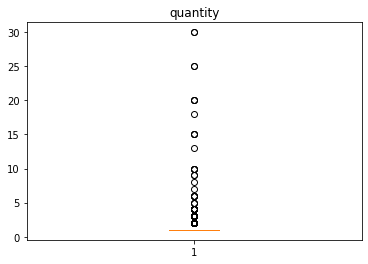

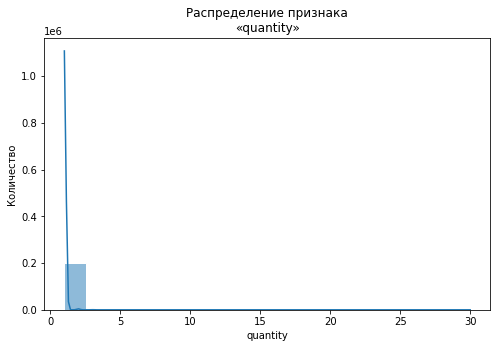

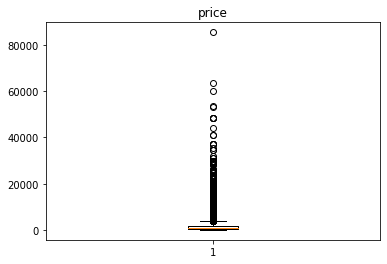

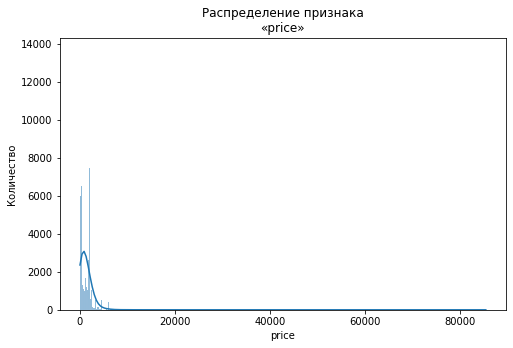

Дискретные признаки не указаны
Категориальные признаки не указаны


In [15]:
int_cols1 = ['quantity','price']
dis_cols1 = []
cat_cols1 = []
purchases.feature_display(int_cols1,dis_cols1,cat_cols1)

Числовые признаки имеют ярко-выраженную ассиметрию и пик в маленьких значениях

Непрерывные признаки не указаны
Дискретные признаки не указаны
Столбчатые диаграммы для категориальных признаков


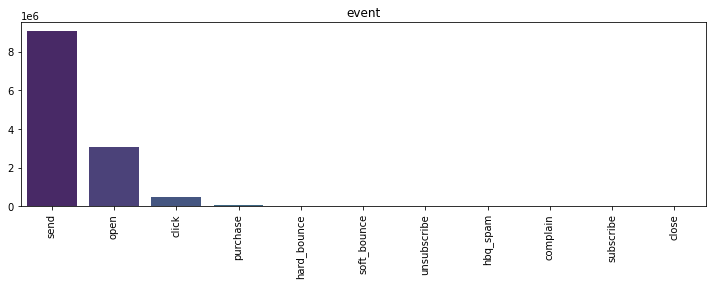

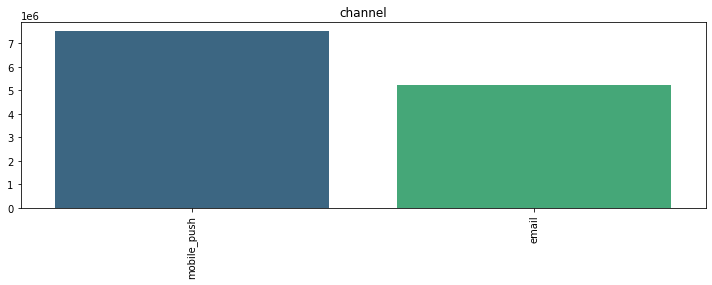

In [16]:
int_cols2 = []
dis_cols2 = []
cat_cols2 = ['event','channel']
messages.feature_display(int_cols2,dis_cols2,cat_cols2)

По категориальным столбцам в таблице с сообщениями видно, что большинство ивентов это отправка и открытие сообщения, а большинство людей получают рассылки в виде пуш-уведомлений

## Создание новых признаков

Создадим новый признак суммы покупки, умножив количество товара на его цену

In [17]:
df_purchases['money'] = df_purchases['price'] * df_purchases['quantity']
svod1 = df_purchases.pivot_table(index='client_id',values='money',aggfunc='sum')
display(svod1)

,money
client_id,
1515915625468060902,6993.0
1515915625468061003,16235.0
1515915625468061099,299.0
1515915625468061100,2098.0
1515915625468061170,33601.0
...,...
1515915626010261344,8994.0
1515915626010266132,1818.0
1515915626010439406,198.0


Создадим новый признак ранга клиента по истории его сообщений

In [18]:
event_rank_map = {
    'open': 1,
    'click': 3,
    'purchase': 5,
    'subscribe': 3,
    'complian': -1,
    'hard_counce': -3,
    'soft_bounce': -1,
    'unsubscribe': -1
}

df_messages['rank'] = df_messages['event'].map(event_rank_map).fillna(0).astype(int)
svod2 = df_messages.pivot_table(index='client_id',values='rank',aggfunc='sum')
display(svod2)

,rank
client_id,
1515915625468060902,89
1515915625468061003,28
1515915625468061099,75
1515915625468061100,170
1515915625468061170,94
...,...
1515915626010183608,2
1515915626010221592,11
1515915626010234726,0


Создадим новый признак с подсчетом количества покупок для каждого клиента

In [19]:
svod3 = df_purchases.pivot_table(index='client_id',values='message_id',aggfunc='count')
display(svod3)

,message_id
client_id,
1515915625468060902,7
1515915625468061003,7
1515915625468061099,1
1515915625468061100,2
1515915625468061170,19
...,...
1515915626010261344,6
1515915626010266132,2
1515915626010439406,2


Создадим катгориальный признак, который будет отображать через какой канао клиент чаще всего получает рассылки

In [20]:
channel_counts = df_messages.groupby(['client_id', 'channel']).size().reset_index(name='count1')

In [21]:
most_frequent_channel = channel_counts.loc[channel_counts.groupby('client_id')['count1'].idxmax()]

In [22]:
svod4 = pd.DataFrame(most_frequent_channel.set_index('client_id')['channel'])
display(svod4) 

,channel
client_id,
1515915625468060902,email
1515915625468061003,email
1515915625468061099,email
1515915625468061100,mobile_push
1515915625468061170,email
...,...
1515915626010183608,mobile_push
1515915626010221592,mobile_push
1515915626010234726,mobile_push


Создадим признак с отображением того в каком месяце чаще всего клиент совершает покупки

In [23]:
df_purchases['date'] = pd.to_datetime(df_purchases['date'])
df_purchases['month'] = df_purchases['date'].dt.month

In [24]:
data_counts = df_purchases.groupby(['client_id', 'month']).size().reset_index(name='count2')

In [25]:
most_frequent_month = data_counts.loc[data_counts.groupby('client_id')['count2'].idxmax()]

In [26]:
svod5 = pd.DataFrame(most_frequent_month.set_index('client_id')['month'])
display(svod5) 

,month
client_id,
1515915625468060902,5
1515915625468061003,1
1515915625468061099,5
1515915625468061100,2
1515915625468061170,3
...,...
1515915626010261344,2
1515915626010266132,2
1515915626010439406,2


Создадим признак, которые будет отображать все категории товаров, которые покупал когда либо клиент

In [27]:
df_purchases['category_ids'] = df_purchases['category_ids'].apply(ast.literal_eval)
svod6 = df_purchases.groupby('client_id')['category_ids'].apply(lambda x: set().union(*x)).reset_index(name='unique_category_ids')

In [28]:
svod6['category_string'] = svod6['unique_category_ids'].apply(lambda x: ','.join(sorted([str(item) for item in x if item is not None])))

In [29]:
svod6 = svod6.set_index('client_id')['category_string']
display(svod6)

client_id
1515915625468060902    1599,176,1828,244,260,27,28,290,4,420,422,432,458
1515915625468061003                                         249,28,4,615
1515915625468061099                                         28,290,4,424
1515915625468061100                                       1828,27,4,5717
1515915625468061170                    18,2,244,258,260,28,4,420,432,441
                                             ...                        
1515915626010261344                                         18,2,212,726
1515915626010266132                                         27,278,4,470
1515915626010439406                                         233,27,4,462
1515915626010443527                                         18,2,274,446
1515915626010443624                                          28,4,62,656
Name: category_string, Length: 49849, dtype: object

Теперь пришло время склеить это все в одну таблицу

In [30]:
df_target = df_target.set_index('client_id')['target']

In [31]:
result = pd.merge(df_target,svod1, left_index=True, right_index=True,how='left')
result = pd.merge(result,svod2, left_index=True, right_index=True,how='left')
result = pd.merge(result,svod3, left_index=True, right_index=True,how='left')
result = pd.merge(result,svod4, left_index=True, right_index=True,how='left')
result = pd.merge(result,svod5, left_index=True, right_index=True,how='left')
result = pd.merge(result,svod6, left_index=True, right_index=True,how='left')

In [32]:
result['channel'] = result['channel'].replace('email',1)
result['channel'] = result['channel'].replace('mobile_push',0)
display(result.head(5))

,target,money,rank,message_id,channel,month,category_string
client_id,,,,,,,
1515915625468060902,0,6993.0,89.0,7,1.0,5,"1599,176,1828,244,260,27,28,290,4,420,422,432,458"
1515915625468061003,1,16235.0,28.0,7,1.0,1,"249,28,4,615"
1515915625468061099,0,299.0,75.0,1,1.0,5,"28,290,4,424"
1515915625468061100,0,2098.0,170.0,2,0.0,2,"1828,27,4,5717"
1515915625468061170,0,33601.0,94.0,19,1.0,3,"18,2,244,258,260,28,4,420,432,441"


In [33]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   target           49849 non-null  int64  
 1   money            49849 non-null  float64
 2   rank             41982 non-null  float64
 3   message_id       49849 non-null  int64  
 4   channel          41982 non-null  float64
 5   month            49849 non-null  int64  
 6   category_string  49849 non-null  object 
dtypes: float64(3), int64(3), object(1)
memory usage: 4.1+ MB


К сожалению, так как некоторые признаки были созданы на основе таблицы с рассылками, оказалось, что в этой таблице не оказалось всех клиентов, для которых требуется выполнить предсказание, так что я предлагаю заполнить числовой столбец медианой, а категориальный модой

In [34]:
result['rank'] = result['rank'].fillna(result['rank'].median())
result['channel'] = result['channel'].fillna(0)
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   target           49849 non-null  int64  
 1   money            49849 non-null  float64
 2   rank             49849 non-null  float64
 3   message_id       49849 non-null  int64  
 4   channel          49849 non-null  float64
 5   month            49849 non-null  int64  
 6   category_string  49849 non-null  object 
dtypes: float64(3), int64(3), object(1)
memory usage: 4.1+ MB


Поглядим на матрицу корреляции

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable money is large: 5504. Are you sure this is not an interval variable? Analysis for pairs of variables including money can be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/bivariate.py:255: UserWarning: Many cells: 2933632. Are interval variables set correctly?
  warnings.warn(


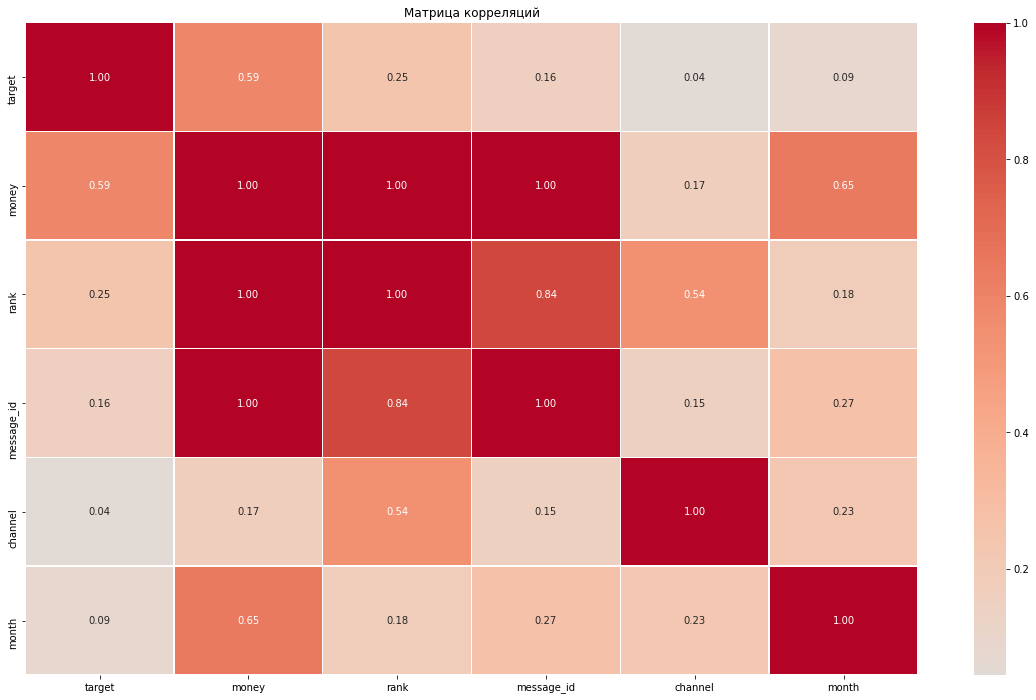

In [35]:
target.df = result.drop('category_string',axis=1)
target.phik_matrix(int_cols=[])

В принципе очень даже неплохо. Утечки целевого признака нет, слишком слабых корреляций тоже нет

## Обучение модели

In [36]:
X = result.drop('target',axis=1)
y = result['target']

num_cols = ['money','rank','message_id']
catboost_cols = ['category_string']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=RANDOM_STATE,test_size=TEST_SIZE)

In [38]:
data_preprocessor = ColumnTransformer(
    [('catboost', CatBoostEncoder(random_state=RANDOM_STATE,verbose=False), catboost_cols),
     ('num', MinMaxScaler(), num_cols)
    ], 
    remainder='passthrough')

In [39]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


param_grid = [
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__kernel': ['linear','poly','rbf','sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': list(range(2, 6)),  
        'models__max_features': list(range(2, 6)), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)], 
        'models__iterations': [100, 300, 500],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__depth': [4, 6, 8],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

In [40]:
r_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [41]:
r_search.fit(X_train, y_train)
print('Лучшая модель')
print()
print(r_search.best_estimator_)
print()
print ('Метрика лучшей модели', r_search.best_score_)
print()
print(r_search.best_params_)

Лучшая модель

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('catboost',
                                                  CatBoostEncoder(random_state=42,
                                                                  verbose=False),
                                                  ['category_string']),
                                                 ('num', 'passthrough',
                                                  ['money', 'rank',
                                                   'message_id'])])),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x7f314a05d6a0>)])

Метрика лучшей модели 0.7106711256087733

{'preprocessor__num': 'passthrough', 'models__learning_rate': 0.1, 'models__iterations': 100, 'models__depth': 4, 'models': <catboost.core.CatBoostClassifier object at 0x7f3149daffd0>}


In [42]:
preds = r_search.predict(X_test)

На данном этапе мы написали пайплайн для подбора гиперпараметров. По итогу поиска мы пришли к выводу, что лучше всего справилась катбустовая модель с learning_rate=0.1, iteration=100, depth=4. Метрика roc-auc получилась равной 0.7106711256087733, что удовлетворяет пороговому значению